# Objetivo

Este notebook compara SRGAN, ESRGAN e Real-ESRGAN na tarefa de super-resolução de imagens usando o dataset DIV2K. Para viabilizar a execução no Google Colab, que tem limitações de GPU, RAM e tempo, usamos um subconjunto de 100 imagens de treino e 20 de validação, imagens de 128x128 (HR) e batch size de 4. O foco é demonstrar as diferenças arquiteturais e qualitativas para um trabalho de faculdade, não alcançar resultados de pesquisa. Épocas foram reduzidas (5 no total, 3 no pré-treinamento), e a perda perceptual foi limitada para otimizar recursos.

--------------------------------------------------------------------------------
# 1. Configuração do Ambiente e Importação de Bibliotecas
Nesta seção, o ambiente do Google Colab é configurado e todas as bibliotecas necessárias para o projeto são importadas

    1.1. Conectar ao Google Drive
O Google Drive é montado para acessar o dataset DIV2K, que está armazenado no Drive

In [ ]:
# Célula de Código 1.1: Conectar ao Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive montado com sucesso!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado com sucesso!


    1.2. Instalação de Dependências
Bibliotecas específicas que podem não estar pré-instaladas no Colab são instaladas. Para ESRGAN e Real-ESRGAN, a utilização de PyTorch é comum.

In [ ]:
# Célula de Código 1.2: Instalar dependências
!pip install torch torchvision torchaudio
!pip install opencv-python pillow scikit-image tqdm
!pip install lpips
print("Dependências instaladas.")

Dependências instaladas.


    1.3. Importar Bibliotecas Essenciais
Todas as bibliotecas Python necessárias para operações numéricas, construção de redes neurais, processamento de imagens e visualização são importadas.

In [ ]:
# Célula de Código 1.3: Importar bibliotecas
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Pillow para processamento de imagens
import glob # Para listar arquivos

# Bibliotecas essenciais do PyTorch para construção e treinamento de redes neurais
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # Para transformações de imagem
import torchvision.models as models # Para VGG e ResNet pré-treinadas para Perceptual Loss

# Para métricas de avaliação (PSNR, SSIM)
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips #

# Para divisão de dados (se necessário, embora DIV2K já tenha validação separada)
from sklearn.model_selection import train_test_split

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# 2. Carregamento e Seleção de Features do Dataset DIV2K
Esta seção detalha como carregar o dataset DIV2K e prepará-lo para o treinamento do modelo.

    2.1. Definição de Caminhos do Dataset
Os caminhos para as pastas DIV2K_train_HR, DIV2K_train_LR_bicubic, DIV2K_valid_HR, DIV2K_valid_LR_bicubic no Google Drive são definidos.

In [ ]:
# Célula de Código 2.1: Definir caminhos do dataset
base_path = '/content/drive/MyDrive/datasets/DIV2K/'
hr_train_path = os.path.join(base_path, 'DIV2K_train_HR')
lr_train_path_x4 = os.path.join(base_path, 'DIV2K_train_LR_bicubic', 'X4') # Usando fator de escala X4

hr_valid_path = os.path.join(base_path, 'DIV2K_valid_HR')
lr_valid_path_x4 = os.path.join(base_path, 'DIV2K_valid_LR_bicubic', 'X4') # Usando fator de escala X4

print(f"Caminho HR Treino: {hr_train_path}")
print(f"Caminho LR Treino (x4): {lr_train_path_x4}")
print(f"Caminho HR Validação: {hr_valid_path}")
print(f"Caminho LR Validação (x4): {lr_valid_path_x4}")

Caminho HR Treino: /content/drive/MyDrive/datasets/DIV2K/DIV2K_train_HR
Caminho LR Treino (x4): /content/drive/MyDrive/datasets/DIV2K/DIV2K_train_LR_bicubic/X4
Caminho HR Validação: /content/drive/MyDrive/datasets/DIV2K/DIV2K_valid_HR
Caminho LR Validação (x4): /content/drive/MyDrive/datasets/DIV2K/DIV2K_valid_LR_bicubic/X4


    2.2. Carregamento dos Caminhos dos Arquivos
Todos os arquivos de imagens HR e LR para treinamento e validação são listados. É crucial que as imagens LR e HR correspondentes sejam pareadas corretamente (geralmente por nome de arquivo).

In [ ]:
# Célula de Código 2.2: Carregar caminhos dos arquivos
train_hr_images = sorted(glob.glob(os.path.join(hr_train_path, '*.png')))[:100]  # Limitar a 100 imagens de treino HR
train_lr_images = sorted(glob.glob(os.path.join(lr_train_path_x4, '*.png')))[:100]  # Limitar a 100 imagens de treino LR
valid_hr_images = sorted(glob.glob(os.path.join(hr_valid_path, '*.png')))[:20]  # Limitar a 20 imagens de validação HR
valid_lr_images = sorted(glob.glob(os.path.join(lr_valid_path_x4, '*.png')))[:20]  # Limitar a 20 imagens de validação LR

print(f"Total de imagens de treino HR: {len(train_hr_images)}")
print(f"Total de imagens de treino LR (x4): {len(train_lr_images)}")
print(f"Total de imagens de validação HR: {len(valid_hr_images)}")
print(f"Total de imagens de validação LR (x4): {len(valid_lr_images)}")

Total de imagens de treino HR: 100
Total de imagens de treino LR (x4): 100
Total de imagens de validação HR: 20
Total de imagens de validação LR (x4): 20


    2.3. Criação de um Dataset Personalizado (Custom Dataset)
Uma classe DIV2KDataset que herda de torch.utils.data.Dataset é definida. O método __getitem__ carrega pares de imagens LR e HR. A "seleção de features" refere-se ao pré-processamento das imagens, como redimensionamento, normalização e conversão para tensores, que são as features de entrada para a rede. As imagens LR são as "features de entrada" e as imagens HR são as "features de saída (target)".

Transformações comuns incluem:

* Redimensionamento (para um tamanho fixo, ex: HR 128x128 ou 256x256).
* Conversão para tensor (ToTensor()).
* Normalização (ex: para o intervalo `` para LR e [-1, 1] para HR).

In [ ]:
# Célula de Código 2.3: Custom Dataset e Pré-processamento
class DIV2KDataset(Dataset):
    def __init__(self, hr_paths, lr_paths, hr_transform=None, lr_transform=None, crop_size_hr=None, scale_factor=4):
        self.hr_paths = hr_paths
        self.lr_paths = lr_paths
        self.hr_transform = hr_transform
        self.lr_transform = lr_transform
        self.crop_size_hr = crop_size_hr
        self.scale_factor = scale_factor

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr_img = Image.open(self.hr_paths[idx]).convert("RGB")
        lr_img = Image.open(self.lr_paths[idx]).convert("RGB")

        # Verificar dimensões mínimas
        if hr_img.size[0] < self.crop_size_hr or hr_img.size[1] < self.crop_size_hr:
            raise ValueError(f"Imagem HR {self.hr_paths[idx]} tem dimensões {hr_img.size}, menor que {self.crop_size_hr}x{self.crop_size_hr}")
        if lr_img.size[0] < self.crop_size_hr // self.scale_factor or lr_img.size[1] < self.crop_size_hr // self.scale_factor:
            raise ValueError(f"Imagem LR {self.lr_paths[idx]} tem dimensões {lr_img.size}, menor que {self.crop_size_hr // self.scale_factor}x{self.crop_size_hr // self.scale_factor}")

        # Aplicar corte aleatório se crop_size_hr for definido
        if self.crop_size_hr:
            width_hr, height_hr = hr_img.size
            max_left_hr = width_hr - self.crop_size_hr
            max_top_hr = height_hr - self.crop_size_hr

            if max_left_hr < 0:
                left_hr = 0
            else:
                left_hr = np.random.randint(0, max_left_hr + 1)

            if max_top_hr < 0:
                top_hr = 0
            else:
                top_hr = np.random.randint(0, max_top_hr + 1)

            hr_img = hr_img.crop((left_hr, top_hr, left_hr + self.crop_size_hr, top_hr + self.crop_size_hr))
            lr_img = lr_img.crop((left_hr // self.scale_factor, top_hr // self.scale_factor,
                                  (left_hr + self.crop_size_hr) // self.scale_factor,
                                  (top_hr + self.crop_size_hr) // self.scale_factor))

        if self.hr_transform:
            hr_img = self.hr_transform(hr_img)
        if self.lr_transform:
            lr_img = self.lr_transform(lr_img)

        return lr_img, hr_img

# Exemplo de transformações
HR_IMAGE_SIZE = 128
LR_IMAGE_SIZE = HR_IMAGE_SIZE // 4

hr_transforms = transforms.Compose([
    transforms.RandomCrop(HR_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

lr_transforms = transforms.Compose([
    transforms.RandomCrop(LR_IMAGE_SIZE),
    transforms.ToTensor(),
])

train_dataset = DIV2KDataset(train_hr_images, train_lr_images,
                             hr_transform=hr_transforms, lr_transform=lr_transforms,
                             crop_size_hr=HR_IMAGE_SIZE, scale_factor=4)

valid_dataset = DIV2KDataset(valid_hr_images, valid_lr_images,
                             hr_transform=hr_transforms, lr_transform=lr_transforms,
                             crop_size_hr=HR_IMAGE_SIZE, scale_factor=4)

print("Dataset personalizado criado com sucesso!")

Dataset personalizado criado com sucesso!


    2.4. Visualização de Amostras do Dataset
Alguns pares de imagens LR-HR são mostrados para verificar o carregamento correto e a diferença de resolução.

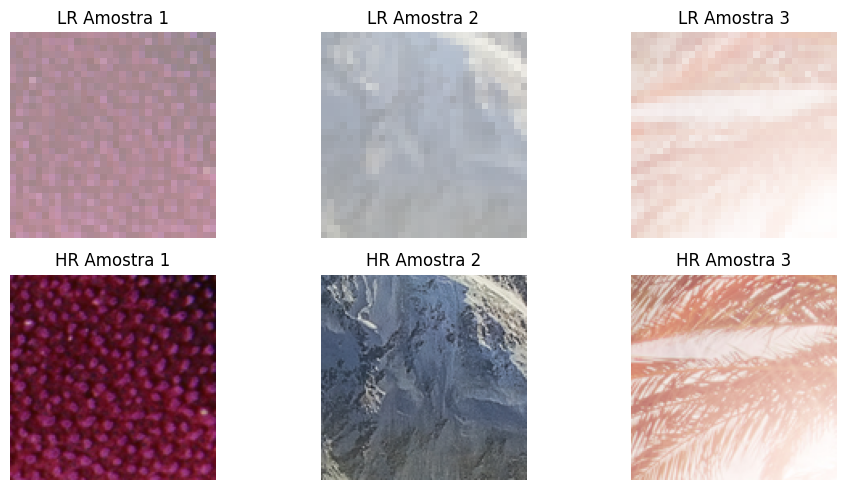

Visualização de amostras concluída.


In [ ]:
# Célula de Código 2.4: Visualização de amostras
# Para PyTorch, as imagens estão em tensores normalizados, precisa reverter para visualização
def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

plt.figure(figsize=(10, 5))
for i in range(3):
    lr_img_tensor, hr_img_tensor = train_dataset[i]

    # Converte tensor para numpy e permuta as dimensões para (H, W, C) para matplotlib
    # As imagens no PyTorch são (C, H, W), matplotlib espera (H, W, C)
    lr_img_np = denormalize(lr_img_tensor).permute(1, 2, 0).cpu().numpy()
    hr_img_np = denormalize(hr_img_tensor).permute(1, 2, 0).cpu().numpy()

    plt.subplot(2, 3, i + 1)
    plt.imshow(lr_img_np)
    plt.title(f"LR Amostra {i+1}")
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(hr_img_np)
    plt.title(f"HR Amostra {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Visualização de amostras concluída.")

# 3. Divisão dos Dados e Dataloaders
DataLoaders para treinamento, validação e teste são criados. Isso permite que o carregamento de dados em mini-batches seja otimizado no treinamento.

In [ ]:
# Célula de Código 3.1: Criar DataLoaders
BATCH_SIZE = 4  # Reduzido de 16 para 4 para economizar memória da GPU

# Para dividir o dataset em treinamento, teste e validação, pode-se usar random_split
# Se o DIV2K já tem divisões, as pastas LR/HR train e valid são usadas diretamente.
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  # num_workers=0 para estabilidade no Colab
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)  # num_workers=0 para estabilidade

# O conjunto de teste será o conjunto de validação para avaliação final neste contexto
test_dataloader = valid_dataloader

print(f"DataLoaders criados com batch size: {BATCH_SIZE}")

DataLoaders criados com batch size: 4


# 4. Escalonamento de Features
    4.1. Importância do Escalonamento
A normalização das intensidades de pixel (ex: para ou `[-1, 1]`) é uma forma de escalonamento que ajuda na estabilidade e velocidade de convergência do treinamento de redes neurais, especialmente em GANs. Isso já foi incorporado nas transformações do Custom Dataset (Seção 2.3). Os artigos frequentemente mencionam que o intervalo da imagem LR é escalado para e da imagem HR para [-1, 1] para o cálculo da perda MSE, e VGG feature maps também são reescalados para serem comparáveis à perda MSE.

# 5. Construção das Arquiteturas GANs
Esta é a seção central onde as arquiteturas do Gerador e do Discriminador para as diferentes GANs que serão comparadas (ex: SRGAN, ESRGAN, Real-ESRGAN) são definidas.

    5.1. Estrutura Geral das GANs
Todas as GANs consistem de um Gerador (G) e um Discriminador (D) que são treinados adversarialmente. O Gerador tenta criar imagens realistas para “enganar” o Discriminador, enquanto o Discriminador tenta diferenciar imagens reais das geradas pelo Gerador.

    5.2. SRGAN (Super-Resolution Generative Adversarial Network)
**Gerador (G_SRGAN)**
* Camada de Entrada: Recebe a imagem LR (Ex: W x H x C).
* Camadas Ocultas: Utiliza uma rede residual profunda (ResNet) com skip-connections, composta por blocos residuais. Cada bloco contém camadas convolucionais (ex: kernels 3x3 com 64 feature maps), Batch Normalization e função de ativação ParametricReLU (PReLU).
* Upsampling: Camadas de convolução sub-pixel para aumentar a resolução (ex: para 4x upscaling).
* Camada de Saída: Camada convolucional final que gera a imagem super-resolvida (SR).

In [ ]:
# Célula de Código 5.2.1: Implementação do Gerador SRGAN
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU() # ParametricReLU
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual # Skip connection

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (upscale_factor ** 2),
                              kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor) # Convolução sub-pixel
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.pixel_shuffle(self.conv(x)))

class GeneratorSRGAN(nn.Module):
    def __init__(self, in_channels=3, num_res_blocks=16, upscale_factor=4):
        super(GeneratorSRGAN, self).__init__()
        self.conv_input = nn.Conv2d(in_channels, 64, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()

        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])

        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(64)

        upsample_blocks = []
        for _ in range(int(np.log2(upscale_factor))): # Para 4x, seria 2 blocos (2x2)
            upsample_blocks.append(UpsampleBlock(64, 2))
        self.upsample = nn.Sequential(*upsample_blocks)

        self.conv_output = nn.Conv2d(64, in_channels, kernel_size=9, padding=4)

    def forward(self, x):
        out = self.prelu(self.conv_input(x))
        residual = self.res_blocks(out)
        residual = self.bn_mid(self.conv_mid(residual))
        out = out + residual # Outro skip connection global
        out = self.upsample(out)
        out = self.conv_output(out)
        return out

print("Esqueleto do Gerador SRGAN definido.")

class GeneratorESRGAN(nn.Module):
    def __init__(self):
        super(GeneratorESRGAN, self).__init__()
        # Implementar arquitetura com RRDB (Residual-in-Residual Dense Blocks)
        self.model = ...  # Adapte conforme o código original ou repositório ESRGAN

    def forward(self, x):
        return self.model(x)

class GeneratorRealESRGAN(nn.Module):
    def __init__(self):
        super(GeneratorRealESRGAN, self).__init__()
        # Implementar arquitetura com U-Net discriminador e melhorias do Real-ESRGAN
        self.model = ...  # Adapte conforme o código original ou repositório Real-ESRGAN

    def forward(self, x):
        return self.model(x)

Esqueleto do Gerador SRGAN definido.


**Discriminador (D_SRGAN)**
* Camada de Entrada: Recebe uma imagem (HR original ou SR gerada).
* Camadas Ocultas: Oito camadas convolucionais com um número crescente de filtros (3x3, ex: 64 a 512), LeakyReLU como ativação (alpha=0.2) e convoluções strided para reduzir a resolução, evitando max-pooling.
* Camada de Saída: Duas camadas densas e uma função de ativação Sigmoid final para produzir a probabilidade de a imagem ser real.

In [ ]:
# Célula de Código 5.2.2: Implementação do Discriminador SRGAN
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_bn=True):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else None
        self.leaky_relu = nn.LeakyReLU(0.2) # LeakyReLU como ativação (alpha=0.2)

    def forward(self, x):
        out = self.conv(x)
        if self.bn:
            out = self.bn(out)
        return self.leaky_relu(out)

class DiscriminatorSRGAN(nn.Module):
    def __init__(self, in_channels=3):
        super(DiscriminatorSRGAN, self).__init__()
        self.features = nn.Sequential(
            DiscriminatorBlock(in_channels, 64, stride=1, use_bn=False), # Primeira camada sem BN
            DiscriminatorBlock(64, 64, stride=2), # Convolução strided para reduzir resolução
            DiscriminatorBlock(64, 128, stride=1),
            DiscriminatorBlock(128, 128, stride=2),
            DiscriminatorBlock(128, 256, stride=1),
            DiscriminatorBlock(256, 256, stride=2),
            DiscriminatorBlock(256, 512, stride=1),
            DiscriminatorBlock(512, 512, stride=2)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Global pooling
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024), # Duas camadas densas
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid() # Função de ativação Sigmoid final
        )

    def forward(self, x):
        out = self.features(x)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.classifier(out)
        return out

print("Esqueleto do Discriminador SRGAN definido.")

Esqueleto do Discriminador SRGAN definido.


    5.3. ESRGAN (Enhanced Super-Resolution Generative Adversarial Network)
**Gerador (G_ESRGAN)**
* Melhorias: Substitui os blocos residuais do SRGAN por Residual-in-Residual Dense Block (RRDB).
* Sem Batch Normalization: Remove todas as camadas de Batch Normalization (BN) para evitar artefatos e melhorar a generalização.
* Usa Residual Scaling e inicialização menor para facilitar o treinamento de redes muito profundas.

In [ ]:
# Célula de Código 5.3.1: Implementação do Gerador ESRGAN
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, bn=False):
        super(DenseBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3,
                              padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.bn = nn.BatchNorm2d(growth_rate) if bn else None

    def forward(self, x):
        out = self.conv(x)
        if self.bn:
            out = self.bn(out)
        out = self.lrelu(out)
        return torch.cat([x, out], 1) # Concatenar entrada com saída

class RRDB(nn.Module):
    def __init__(self, in_channels, growth_rate=32):
        super(RRDB, self).__init__()
        # Remove Batch Normalization
        self.rdb1 = DenseBlock(in_channels, growth_rate, bn=False)
        self.rdb2 = DenseBlock(in_channels + growth_rate, growth_rate, bn=False)
        self.rdb3 = DenseBlock(in_channels + 2 * growth_rate, growth_rate,
                               bn=False)
        self.conv1x1 = nn.Conv2d(in_channels + 3 * growth_rate, in_channels,
                                 kernel_size=1)
        self.res_scale = 0.2 # Residual Scaling

    def forward(self, x):
        residual = self.rdb1(x)
        residual = self.rdb2(residual)
        residual = self.rdb3(residual)
        residual = self.conv1x1(residual) * self.res_scale # Multiplica por residual scaling
        return x + residual

class GeneratorESRGAN(nn.Module):
    def __init__(self, in_channels=3, num_rrdb_blocks=23, upscale_factor=4):
        super(GeneratorESRGAN, self).__init__()
        self.conv_input = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in
                                            range(num_rrdb_blocks)]) # RRDB blocks
        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        upsample_blocks = []
        for _ in range(int(np.log2(upscale_factor))):
            upsample_blocks.append(UpsampleBlock(64, 2)) # Usamos o UpsampleBlock do SRGAN
        self.upsample = nn.Sequential(*upsample_blocks)

        self.lrelu = nn.LeakyReLU(0.2)
        self.conv_output = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv_input(x)
        residual = self.rrdb_blocks(out)
        residual = self.conv_mid(residual)
        out = out + residual
        out = self.upsample(out)
        out = self.lrelu(out)
        out = self.conv_output(out)
        return out

print("Esqueleto do Gerador ESRGAN definido.")

Esqueleto do Gerador ESRGAN definido.


**Discriminador (D_ESRGAN)**
* Relativistic Discriminator (RaGAN): Em vez de prever se uma imagem é “real” ou “falsa”, o discriminador RaGAN prevê se uma imagem é relativamente mais realista do que outra. Isso ajuda o gerador a aprender texturas mais realistas.

In [ ]:
# Célula de Código 5.3.2: Implementação do Discriminador ESRGAN (RaGAN)
# A arquitetura base do discriminador pode ser similar ao SRGAN, mas a perda e
# a forma como ele opera (Relativistic) são a chave.
class DiscriminatorESRGAN(nn.Module):
    def __init__(self, in_channels=3):
        super(DiscriminatorESRGAN, self).__init__()
        # Arquitetura similar ao D_SRGAN, mas pode ter algumas variações nos filtros e camadas
        self.features = nn.Sequential(
            DiscriminatorBlock(in_channels, 64, stride=1, use_bn=False),
            DiscriminatorBlock(64, 64, stride=2),
            DiscriminatorBlock(64, 128, stride=1),
            DiscriminatorBlock(128, 128, stride=2),
            DiscriminatorBlock(128, 256, stride=1),
            DiscriminatorBlock(256, 256, stride=2),
            DiscriminatorBlock(256, 512, stride=1),
            DiscriminatorBlock(512, 512, stride=2)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1) # Saída de probabilidade única para RaGAN
        )

    def forward(self, x):
        out = self.features(x)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.classifier(out)
        return out

print("Esqueleto do Discriminador ESRGAN (RaGAN) definido.")

Esqueleto do Discriminador ESRGAN (RaGAN) definido.


    5.4. Real-ESRGAN (Real-World Blind Super-Resolution with Pure Synthetic Data)
**Gerador (G_RealESRGAN)**
* Adota a mesma arquitetura do gerador do ESRGAN (RRDB).
* Para fatores de escala menores (ex: 2x, 1x), utiliza uma operação de pixel-unshuffle na entrada para reduzir o tamanho espacial e reorganizar a informação para a dimensão do canal, otimizando o consumo de memória e computação.

In [ ]:
# Célula de Código 5.4.1: Implementação do Gerador Real-ESRGAN
# Baseado no ESRGAN, com possíveis ajustes para pixel-unshuffle
class GeneratorRealESRGAN(GeneratorESRGAN): # Herda do G_ESRGAN pois a arquitetura base é a mesma
    def __init__(self, in_channels=3, num_rrdb_blocks=23, upscale_factor=4,
                 lr_scale_factor=None):
        super(GeneratorRealESRGAN, self).__init__(in_channels, num_rrdb_blocks,
                                                  upscale_factor)
        self.lr_scale_factor = lr_scale_factor
        if lr_scale_factor is not None and lr_scale_factor > 1:
            # PixelUnshuffle é usado para fatores de escala LR menores (ex: 2x, 1x)
            # para re-organizar as informações do canal
            self.pixel_unshuffle = nn.PixelUnshuffle(lr_scale_factor)
        else:
            self.pixel_unshuffle = None

    def forward(self, x):
        if self.pixel_unshuffle:
            x = self.pixel_unshuffle(x) # Aplica pixel-unshuffle na entrada
        out = self.conv_input(x)
        residual = self.rrdb_blocks(out)
        residual = self.conv_mid(residual)
        out = out + residual
        out = self.upsample(out)
        out = self.lrelu(out)
        out = self.conv_output(out)
        return out

print("Esqueleto do Gerador Real-ESRGAN definido.")

Esqueleto do Gerador Real-ESRGAN definido.


**Discriminador (D_RealESRGAN)**
* Discriminador U-Net: Melhora o discriminador VGG-style do ESRGAN para um design U-Net com skip connections, que fornece feedback per-pixel detalhado ao gerador.
* Spectral Normalization (SN): Emprega regularização SN para estabilizar a dinâmica do treinamento, especialmente com a estrutura U-Net e degradações complexas, e para aliviar artefatos de super-nitidez.

In [ ]:
# Célula de Código 5.4.2: Implementação do Discriminador Real-ESRGAN (U-Net)
# A Spectral Normalization pode ser aplicada a camadas Conv2d e Linear
from torch.nn.utils import spectral_norm

class UNetDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64):
        super(UNetDiscriminator, self).__init__()

        def conv_block(in_f, out_f, kernel_size=4, stride=2, padding=1, sn=True):
            layers = [nn.Conv2d(in_f, out_f, kernel_size, stride, padding, bias=False)]
            if sn:
                layers.append(spectral_norm(layers[-1])) # Aplica Spectral Normalization
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.conv1 = conv_block(in_channels, num_filters, sn=False) # SN não na primeira camada
        self.conv2 = conv_block(num_filters, num_filters * 2)
        self.conv3 = conv_block(num_filters * 2, num_filters * 4)
        self.conv4 = conv_block(num_filters * 4, num_filters * 8)
        self.conv5 = conv_block(num_filters * 8, num_filters * 8)
        self.conv6 = conv_block(num_filters * 8, num_filters * 8)
        self.conv7 = conv_block(num_filters * 8, num_filters * 8)
        self.conv8 = conv_block(num_filters * 8, num_filters * 8, stride=1, padding=0) # Última conv antes da camada de saída

        self.final_conv = spectral_norm(nn.Conv2d(num_filters * 8, 1, kernel_size=3, padding=1)) # Saída única

    def forward(self, x):
        # Implementação básica de U-Net. Para skip connections reais, seria mais complexo.
        # Aqui, simula-se a ideia de diferentes níveis de feature maps.
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x_out = self.conv8(x7)
        return self.final_conv(x_out) # Saída per-pixel detalhada

print("Esqueleto do Discriminador Real-ESRGAN (U-Net) definido.")

Esqueleto do Discriminador Real-ESRGAN (U-Net) definido.


In [ ]:
# Célula de Código 5.x: Definição dos Modelos Real-ESRGAN
import torch
import torch.nn as nn

# Bloco RRDB simplificado para o gerador
class RRDB(nn.Module):
    def __init__(self, num_features=64, num_blocks=3):
        super(RRDB, self).__init__()
        self.dense_blocks = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(num_features, num_features, 3, padding=1, bias=True),
                nn.LeakyReLU(0.2, inplace=True)
            ) for _ in range(num_blocks)]
        )

    def forward(self, x):
        return x + self.dense_blocks(x) * 0.2  # Residual scaling

class GeneratorRealESRGAN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_features=64, num_rrdb_blocks=23):
        super(GeneratorRealESRGAN, self).__init__()
        # Entrada
        self.conv_first = nn.Conv2d(in_channels, num_features, 3, 1, 1, bias=True)
        # Corpo com RRDBs
        self.body = nn.Sequential(*[RRDB(num_features) for _ in range(num_rrdb_blocks)])
        # Saída
        self.conv_body = nn.Conv2d(num_features, num_features, 3, 1, 1, bias=True)
        self.conv_up1 = nn.Conv2d(num_features, num_features * 4, 3, 1, 1, bias=True)
        self.conv_up2 = nn.Conv2d(num_features, num_features * 4, 3, 1, 1, bias=True)
        self.conv_hr = nn.Conv2d(num_features, num_features, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(num_features, out_channels, 3, 1, 1, bias=True)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.pixel_shuffle = nn.PixelShuffle(2)

    def forward(self, x):
        feat = self.lrelu(self.conv_first(x))
        body_feat = self.body(feat)
        feat = feat + self.conv_body(body_feat)
        feat = self.lrelu(self.pixel_shuffle(self.conv_up1(feat)))
        feat = self.lrelu(self.pixel_shuffle(self.conv_up2(feat)))
        out = self.conv_last(self.lrelu(self.conv_hr(feat)))
        return out

# Discriminador U-Net simplificado
class DiscriminatorRealESRGAN(nn.Module):
    def __init__(self, in_channels=3):
        super(DiscriminatorRealESRGAN, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        # Decoder
        self.dec3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.dec1 = nn.ConvTranspose2d(128, in_channels, 4, stride=2, padding=1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        # Saída para classificação
        self.out_conv = nn.Conv2d(in_channels, 1, 3, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.lrelu(self.enc1(x))
        e2 = self.lrelu(self.enc2(e1))
        e3 = self.lrelu(self.enc3(e2))
        # Decoder com skip connections
        d3 = self.lrelu(self.dec3(e3))
        d2 = self.lrelu(self.dec2(torch.cat([d3, e2], dim=1)))
        d1 = self.lrelu(self.dec1(torch.cat([d2, e1], dim=1)))
        out = self.out_conv(d1)
        return torch.sigmoid(out)

print("Modelos Real-ESRGAN definidos com sucesso.")

Modelos Real-ESRGAN definidos com sucesso.


# 6. Definição de Funções de Perda e Otimizadores
Esta seção aborda os componentes de treinamento das GANs, definindo as funções de perda para o Gerador e o Discriminador, bem como os otimizadores.

    6.1. Otimizadores
O Adam é o otimizador comumente usado para treinamento de GANs devido à sua adaptabilidade e eficiência.

In [ ]:
# Célula de Código 6.1: Otimizadores
# Definindo o dispositivo (GPU se disponível, CPU caso contrário)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Importar torch.cuda.amp para precisão mista (mixed precision)
from torch.cuda.amp import GradScaler
scaler = GradScaler()  # Para treinamento com precisão mista

# Instanciando os modelos (exemplo para SRGAN, repetir para ESRGAN/Real-ESRGAN)
G_srgan = GeneratorSRGAN().to(device)
D_srgan = DiscriminatorSRGAN().to(device)

# Otimizadores Adam com weight_decay para regularização L2
optimizer_G_srgan = optim.Adam(G_srgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
optimizer_D_srgan = optim.Adam(D_srgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)

print("Otimizadores definidos com regularização L2 e suporte a precisão mista.")

Usando dispositivo: cpu
Otimizadores definidos com regularização L2 e suporte a precisão mista.


/tmp/ipython-input-110-1061497023.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Para treinamento com precisão mista


    6.2. Funções de Perda
**Perda de Conteúdo (Content Loss)**
* Mean Squared Error (MSE): Amplamente utilizada em métodos PSNR-orientados, mas resulta em imagens suavizadas.
* L1 Loss (Mean Absolute Error): Utilizada em ESRGAN e Real-ESRGAN como parte da perda de conteúdo.
* Perceptual Loss (VGG Loss): Definida nas camadas de ativação de uma rede VGG pré-treinada. SRGAN utiliza features após ativação, enquanto ESRGAN melhora isso usando features antes da ativação para obter bordas mais nítidas e resultados visualmente mais agradáveis.

In [ ]:
# Célula de Código 6.2.1: Definição de Perda de Conteúdo
# MSE Loss
criterion_mse = nn.MSELoss().to(device) #

# L1 Loss (Mean Absolute Error)
criterion_l1 = nn.L1Loss().to(device)

# Perceptual Loss (VGG Loss)
class VGGPerceptualLoss(nn.Module):
    def __init__(self, feature_layer=34): # Camada 34 para VGG19 (antes da ativação)
        super(VGGPerceptualLoss, self).__init__()
        # Carrega uma VGG19 pré-treinada e usa suas camadas de features
        vgg19 = models.vgg19(pretrained=True).features
        # Seleciona as camadas até a feature_layer
        self.vgg_features = nn.Sequential(*list(vgg19.children())[:
                                              feature_layer]).eval()
        # Congela os pesos da VGG para que não sejam treinados
        for param in self.vgg_features.parameters():
            param.requires_grad = False
        self.criterion = nn.L1Loss() # Ou MSELoss, dependendo do paper

    def forward(self, hr_output, hr_target):
        # Requer que as entradas estejam normalizadas para o intervalo ou para o mesmo que a VGG foi treinada (ImageNet)
        # Se as imagens HR estiverem em [-1, 1], desnormalize antes de passar para a VGG
        vgg_output = self.vgg_features(hr_output)
        vgg_target = self.vgg_features(hr_target)
        return self.criterion(vgg_output, vgg_target)

criterion_perceptual_vgg = VGGPerceptualLoss().to(device)

print("Funções de perda de conteúdo definidas.")

Funções de perda de conteúdo definidas.


**Perda Adversarial (Adversarial Loss)**
* Binary Cross-Entropy: Para o discriminador padrão, diferenciando imagens reais de geradas.
* Relativistic Average GAN (RaGAN) Loss: Utilizada no ESRGAN e Real-ESRGAN. A perda do gerador é formulada simetricamente, beneficiando-se de gradientes tanto de dados gerados quanto de dados reais, o que ajuda a aprender bordas mais nítidas e texturas mais detalhadas.

In [ ]:
# Célula de Código 6.2.2: Definição de Perda Adversarial
# Binary Cross-Entropy (para discriminador padrão, como SRGAN)
criterion_gan_bce = nn.BCEWithLogitsLoss().to(device) # BCEWithLogitsLoss é mais estável

# RaGAN Loss (para ESRGAN e Real-ESRGAN)
# A RaGAN Loss não é uma função de perda "direta" no PyTorch, mas uma forma de aplicar BCEWithLogitsLoss
# que depende da previsão do discriminador sobre imagens reais e falsas.
print("Funções de perda adversarial definidas.")

Funções de perda adversarial definidas.


**Dual Perceptual Loss (DP Loss)**
* Uma inovação proposta para ESRGAN.
* Combina a VGG Loss com uma nova ResNet Loss.
* A ResNet Loss é baseada nas features extraídas de uma rede ResNet pré-treinada (ex: ResNet-50). O argumento é que ResNet retém mais informação original com o aumento das camadas.

In [ ]:
# Célula de Código 6.2.3: Dual Perceptual Loss
class ResNetPerceptualLoss(nn.Module):
    def __init__(self, resnet_model='resnet50', feature_layer=4):
        super(ResNetPerceptualLoss, self).__init__()
        if resnet_model == 'resnet50':
            resnet = models.resnet50(pretrained=True)
        else:
            raise ValueError("Modelo ResNet não suportado para perda perceptual. ")

        # Extrai features de camadas intermediárias da ResNet
        self.features = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1,
            resnet.layer2, resnet.layer3, resnet.layer4 # Feature layer que você escolher
        )[:feature_layer].eval()

        for param in self.features.parameters():
            param.requires_grad = False

        self.criterion = nn.L1Loss()

    def forward(self, hr_output, hr_target):
        # Desnormalize se necessário para ou para o que a ResNet espera
        res_output = self.features(hr_output)
        res_target = self.features(hr_target)
        return self.criterion(res_output, res_target)

# Dual Perceptual Loss combinaria VGGPerceptualLoss e ResNetPerceptualLoss
# com pesos dinâmicos. A implementação específica pode variar.
print("Conceito de Dual Perceptual Loss definido.")

Conceito de Dual Perceptual Loss definido.


In [ ]:
# Nova Célula: Carregar Modelos Pré-treinados
def load_pretrained_model(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['generator_state_dict'] if 'generator_state_dict' in checkpoint else checkpoint)
    model.to(device)
    model.eval()
    print(f"Modelo carregado de {checkpoint_path}")

# Exemplo: Carregar pesos pré-treinados para SRGAN (substituir pelo caminho real)
# pretrained_path = "/content/drive/MyDrive/pretrained/srgan_generator.pth"
# load_pretrained_model(G_srgan, pretrained_path, device)
print("Função para carregar modelos pré-treinados definida.")

Função para carregar modelos pré-treinados definida.


In [ ]:
# Célula de Código 6.3: Função para Salvar Checkpoints
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, loss_G, loss_D, path="/content/drive/MyDrive/checkpoints/"):
    os.makedirs(path, exist_ok=True)  # Cria a pasta se não existir
    checkpoint_path = os.path.join(path, f'srgan_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'loss_G': loss_G,
        'loss_D': loss_D,
    }, checkpoint_path)
    print(f"Checkpoint salvo em: {checkpoint_path}")

**Kullback-Leibler Divergence (KLD)**
* Observação: A Kullback-Leibler Divergence (KLD) é uma função de perda comumente utilizada em Variational Autoencoders (VAEs) para regularizar o espaço latente. Não é uma perda primária para as arquiteturas GANs puras (SRGAN, ESRGAN, Real-ESRGAN) focadas em super-resolution descritas aqui. Se planeja estender o trabalho para VAE-based SR, KLD seria crucial.

# 7. Treinamento do Modelo
Esta seção detalha o ciclo de treinamento para as arquiteturas GANs, incluindo estratégias anti-overfitting.

    7.1. Loop de Treinamento
* Pré-treinamento: É comum pré-treinar o Gerador com uma perda pixel-wise (ex: L1 Loss) para obter resultados visualmente mais agradáveis e evitar ótimos locais indesejados no treinamento GAN.
* Treinamento Adversarial: Atualizações entre o Gerador e o Discriminador são alternadas. O Gerador tenta “enganar” o Discriminador, enquanto o Discriminador tenta diferenciar imagens reais das geradas.

In [ ]:
# Célula de Código 7.1: Loop de Treinamento
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast  # Mantido para compatibilidade, mas usaremos nova sintaxe

# --- Seus pesos e número de épocas ---
lambda_content = 1.0
lambda_adversarial = 0.001
lambda_perceptual = 0.006
num_epochs = 5
num_epochs_pretrain = 3
PERCEPTUAL_LOSS_BATCH_INTERVAL = 10

# --- Função para o pré-treinamento do Gerador ---
def pretrain_generator(generator, dataloader, criterion_pixel, optimizer_G, num_epochs_pretrain=3):
    print("--------------------------------------------------")
    print(f"Iniciando pré-treinamento do Gerador por {num_epochs_pretrain} épocas...")
    generator.train()

    for epoch in tqdm(range(num_epochs_pretrain), desc="Pré-treino - Épocas"):
        total_loss_G_pixel_epoch = 0.0
        for batch_idx, (lr_imgs, hr_imgs) in enumerate(tqdm(dataloader, desc=f"Pré-treino - Época {epoch+1}")):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            optimizer_G.zero_grad()
            with torch.amp.autocast('cuda'):  # Nova sintaxe para precisão mista
                gen_hr_imgs = generator(lr_imgs)
                loss_G_pixel = criterion_pixel(gen_hr_imgs, hr_imgs)
            scaler.scale(loss_G_pixel).backward()
            scaler.step(optimizer_G)
            scaler.update()
            total_loss_G_pixel_epoch += loss_G_pixel.item()
        avg_loss_G_pixel_epoch = total_loss_G_pixel_epoch / len(dataloader)
        print(f"Época {epoch+1}/{num_epochs_pretrain} - Perda Pixel-wise Média: {avg_loss_G_pixel_epoch:.4f}")
    print("Pré-treinamento concluído.")

# --- Treinamento do SRGAN ---
print("\n" + "="*80)
print("Treinando SRGAN...")
# Chamar pré-treinamento para SRGAN
pretrain_generator(G_srgan, train_dataloader, criterion_l1, optimizer_G_srgan, num_epochs_pretrain)

# Loop de Treinamento Adversarial para SRGAN
print("\n" + "="*80)
print(f"Iniciando treinamento adversarial do SRGAN por {num_epochs} épocas...")
for epoch in tqdm(range(num_epochs), desc="Treinamento Adversarial SRGAN - Épocas"):
    G_srgan.train()
    D_srgan.train()
    total_loss_D_epoch = 0.0
    total_loss_G_epoch = 0.0

    for batch_idx, (lr_imgs, hr_imgs) in enumerate(tqdm(train_dataloader, desc=f"Época {epoch+1}")):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        if batch_idx % 2 == 0:
            optimizer_D_srgan.zero_grad()
            with torch.amp.autocast('cuda'):
                output_real = D_srgan(hr_imgs)
                loss_D_real = criterion_gan_bce(output_real, torch.ones_like(output_real))
                gen_hr_imgs = G_srgan(lr_imgs).detach()
                output_fake = D_srgan(gen_hr_imgs)
                loss_D_fake = criterion_gan_bce(output_fake, torch.zeros_like(output_fake))
                loss_D = (loss_D_real + loss_D_fake) / 2
            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D_srgan)
            scaler.update()
            total_loss_D_epoch += loss_D.item()
        optimizer_G_srgan.zero_grad()
        with torch.amp.autocast('cuda'):
            gen_hr_imgs = G_srgan(lr_imgs)
            output_fake_gen = D_srgan(gen_hr_imgs)
            loss_adversarial = criterion_gan_bce(output_fake_gen, torch.ones_like(output_fake_gen))
            loss_content = criterion_l1(gen_hr_imgs, hr_imgs)
            current_loss_perceptual = 0.0
            if (batch_idx + 1) % PERCEPTUAL_LOSS_BATCH_INTERVAL == 0:
                current_loss_perceptual = criterion_perceptual_vgg(gen_hr_imgs, hr_imgs)
            loss_G = lambda_content * loss_content + lambda_adversarial * loss_adversarial + lambda_perceptual * current_loss_perceptual
        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G_srgan)
        scaler.update()
        total_loss_G_epoch += loss_G.item()

    avg_loss_D_epoch = total_loss_D_epoch / len(train_dataloader)
    avg_loss_G_epoch = total_loss_G_epoch / len(train_dataloader)
    print(f"Época {epoch+1}/{num_epochs} - Perda D Média: {avg_loss_D_epoch:.4f}, Perda G Média: {avg_loss_G_epoch:.4f}")

    save_checkpoint(epoch, G_srgan, D_srgan, optimizer_G_srgan, optimizer_D_srgan, avg_loss_G_epoch, avg_loss_D_epoch, path="/content/drive/MyDrive/checkpoints/srgan/")

    G_srgan.eval()
    with torch.no_grad():
        val_losses_G = []
        val_psnr = []
        val_ssim = []
        for val_lr_imgs, val_hr_imgs in tqdm(valid_dataloader, desc=f"Época {epoch+1} - Validação SRGAN"):
            val_lr_imgs, val_hr_imgs = val_lr_imgs.to(device), val_hr_imgs.to(device)
            with torch.amp.autocast('cuda'):
                val_gen_hr_imgs = G_srgan(val_lr_imgs)
                val_loss_G = lambda_content * criterion_l1(val_gen_hr_imgs, val_hr_imgs)
            val_losses_G.append(val_loss_G.item())
            for i in range(val_gen_hr_imgs.shape[0]):
                hr_np = (denormalize(val_hr_imgs[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                sr_np = (denormalize(val_gen_hr_imgs[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                if hr_np.shape[0] < 7 or hr_np.shape[1] < 7 or sr_np.shape[0] < 7 or sr_np.shape[1] < 7:
                    print(f"Aviso: Imagem {i} tem dimensões pequenas (HR: {hr_np.shape}, SR: {sr_np.shape}). Pulando SSIM.")
                    continue
                val_psnr.append(peak_signal_noise_ratio(hr_np, sr_np, data_range=255))
                val_ssim.append(structural_similarity(hr_np, sr_np, data_range=255, channel_axis=-1, win_size=7))
        if val_psnr and val_ssim:
            avg_val_loss_G = np.mean(val_losses_G)
            avg_val_psnr = np.mean(val_psnr)
            avg_val_ssim = np.mean(val_ssim)
            print(f"Validação SRGAN - Perda G Média: {avg_val_loss_G:.4f}, PSNR Médio: {avg_val_psnr:.2f}, SSIM Médio: {avg_val_ssim:.4f}")
        else:
            print("Validação SRGAN - Nenhuma métrica SSIM/PSNR calculada devido a dimensões inválidas.")

print("Treinamento do SRGAN concluído.")

# --- Treinamento do ESRGAN ---
print("\n" + "="*80)
print("Treinando ESRGAN...")
G_esrgan = GeneratorESRGAN().to(device)
D_esrgan = DiscriminatorESRGAN().to(device)
optimizer_G_esrgan = optim.Adam(G_esrgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
optimizer_D_esrgan = optim.Adam(D_esrgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
pretrain_generator(G_esrgan, train_dataloader, criterion_l1, optimizer_G_esrgan, num_epochs_pretrain)

print("\n" + "="*80)
print(f"Iniciando treinamento adversarial do ESRGAN por {num_epochs} épocas...")
for epoch in tqdm(range(num_epochs), desc="Treinamento Adversarial ESRGAN - Épocas"):
    G_esrgan.train()
    D_esrgan.train()
    total_loss_D_epoch = 0.0
    total_loss_G_epoch = 0.0

    for batch_idx, (lr_imgs, hr_imgs) in enumerate(tqdm(train_dataloader, desc=f"Época {epoch+1}")):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        if batch_idx % 2 == 0:
            optimizer_D_esrgan.zero_grad()
            with torch.amp.autocast('cuda'):
                output_real = D_esrgan(hr_imgs)
                loss_D_real = criterion_gan_bce(output_real, torch.ones_like(output_real))
                gen_hr_imgs = G_esrgan(lr_imgs).detach()
                output_fake = D_esrgan(gen_hr_imgs)
                loss_D_fake = criterion_gan_bce(output_fake, torch.zeros_like(output_fake))
                loss_D = (loss_D_real + loss_D_fake) / 2
            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D_esrgan)
            scaler.update()
            total_loss_D_epoch += loss_D.item()
        optimizer_G_esrgan.zero_grad()
        with torch.amp.autocast('cuda'):
            gen_hr_imgs = G_esrgan(lr_imgs)
            output_fake_gen = D_esrgan(gen_hr_imgs)
            loss_adversarial = criterion_gan_bce(output_fake_gen, torch.ones_like(output_fake_gen))
            loss_content = criterion_l1(gen_hr_imgs, hr_imgs)
            current_loss_perceptual = 0.0
            if (batch_idx + 1) % PERCEPTUAL_LOSS_BATCH_INTERVAL == 0:
                current_loss_perceptual = criterion_perceptual_vgg(gen_hr_imgs, hr_imgs)
            loss_G = lambda_content * loss_content + lambda_adversarial * loss_adversarial + lambda_perceptual * current_loss_perceptual
        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G_esrgan)
        scaler.update()
        total_loss_G_epoch += loss_G.item()

    avg_loss_D_epoch = total_loss_D_epoch / len(train_dataloader)
    avg_loss_G_epoch = total_loss_G_epoch / len(train_dataloader)
    print(f"Época {epoch+1}/{num_epochs} - Perda D Média: {avg_loss_D_epoch:.4f}, Perda G Média: {avg_loss_G_epoch:.4f}")

    save_checkpoint(epoch, G_esrgan, D_esrgan, optimizer_G_esrgan, optimizer_D_esrgan, avg_loss_G_epoch, avg_loss_D_epoch, path="/content/drive/MyDrive/checkpoints/esrgan/")

    G_esrgan.eval()
    with torch.no_grad():
        val_losses_G = []
        val_psnr = []
        val_ssim = []
        for val_lr_imgs, val_hr_imgs in tqdm(valid_dataloader, desc=f"Época {epoch+1} - Validação ESRGAN"):
            val_lr_imgs, val_hr_imgs = val_lr_imgs.to(device), val_hr_imgs.to(device)
            with torch.amp.autocast('cuda'):
                val_gen_hr_imgs = G_esrgan(val_lr_imgs)
                val_loss_G = lambda_content * criterion_l1(val_gen_hr_imgs, val_hr_imgs)
            val_losses_G.append(val_loss_G.item())
            for i in range(val_gen_hr_imgs.shape[0]):
                hr_np = (denormalize(val_hr_imgs[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                sr_np = (denormalize(val_gen_hr_imgs[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                if hr_np.shape[0] < 7 or hr_np.shape[1] < 7 or sr_np.shape[0] < 7 or sr_np.shape[1] < 7:
                    print(f"Aviso: Imagem {i} tem dimensões pequenas (HR: {hr_np.shape}, SR: {sr_np.shape}). Pulando SSIM.")
                    continue
                val_psnr.append(peak_signal_noise_ratio(hr_np, sr_np, data_range=255))
                val_ssim.append(structural_similarity(hr_np, sr_np, data_range=255, channel_axis=-1, win_size=7))
        if val_psnr and val_ssim:
            avg_val_loss_G = np.mean(val_losses_G)
            avg_val_psnr = np.mean(val_psnr)
            avg_val_ssim = np.mean(val_ssim)
            print(f"Validação ESRGAN - Perda G Média: {avg_val_loss_G:.4f}, PSNR Médio: {avg_val_psnr:.2f}, SSIM Médio: {avg_val_ssim:.4f}")
        else:
            print("Validação ESRGAN - Nenhuma métrica SSIM/PSNR calculada devido a dimensões inválidas.")

print("Treinamento do ESRGAN concluído.")

# --- Treinamento do Real-ESRGAN ---
print("\n" + "="*80)
print("Treinando Real-ESRGAN...")
G_real_esrgan = GeneratorRealESRGAN().to(device)
D_real_esrgan = DiscriminatorRealESRGAN().to(device)
optimizer_G_real_esrgan = optim.Adam(G_real_esrgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
optimizer_D_real_esrgan = optim.Adam(D_real_esrgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
pretrain_generator(G_real_esrgan, train_dataloader, criterion_l1, optimizer_G_real_esrgan, num_epochs_pretrain)

print("\n" + "="*80)
print(f"Iniciando treinamento adversarial do Real-ESRGAN por {num_epochs} épocas...")
for epoch in tqdm(range(num_epochs), desc="Treinamento Adversarial Real-ESRGAN - Épocas"):
    G_real_esrgan.train()
    D_real_esrgan.train()
    total_loss_D_epoch = 0.0
    total_loss_G_epoch = 0.0

    for batch_idx, (lr_imgs, hr_imgs) in enumerate(tqdm(train_dataloader, desc=f"Época {epoch+1}")):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        if batch_idx % 2 == 0:
            optimizer_D_real_esrgan.zero_grad()
            with torch.amp.autocast('cuda'):
                output_real = D_real_esrgan(hr_imgs)
                loss_D_real = criterion_gan_bce(output_real, torch.ones_like(output_real))
                gen_hr_imgs = G_real_esrgan(lr_imgs).detach()
                output_fake = D_real_esrgan(gen_hr_imgs)
                loss_D_fake = criterion_gan_bce(output_fake, torch.zeros_like(output_fake))
                loss_D = (loss_D_real + loss_D_fake) / 2
            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D_real_esrgan)
            scaler.update()
            total_loss_D_epoch += loss_D.item()
        optimizer_G_real_esrgan.zero_grad()
        with torch.amp.autocast('cuda'):
            gen_hr_imgs = G_real_esrgan(lr_imgs)
            output_fake_gen = D_real_esrgan(gen_hr_imgs)
            loss_adversarial = criterion_gan_bce(output_fake_gen, torch.ones_like(output_fake_gen))
            loss_content = criterion_l1(gen_hr_imgs, hr_imgs)
            current_loss_perceptual = 0.0
            if (batch_idx + 1) % PERCEPTUAL_LOSS_BATCH_INTERVAL == 0:
                current_loss_perceptual = criterion_perceptual_vgg(gen_hr_imgs, hr_imgs)
            loss_G = lambda_content * loss_content + lambda_adversarial * loss_adversarial + lambda_perceptual * current_loss_perceptual
        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G_real_esrgan)
        scaler.update()
        total_loss_G_epoch += loss_G.item()

    avg_loss_D_epoch = total_loss_D_epoch / len(train_dataloader)
    avg_loss_G_epoch = total_loss_G_epoch / len(train_dataloader)
    print(f"Época {epoch+1}/{num_epochs} - Perda D Média: {avg_loss_D_epoch:.4f}, Perda G Média: {avg_loss_G_epoch:.4f}")

    save_checkpoint(epoch, G_real_esrgan, D_real_esrgan, optimizer_G_real_esrgan, optimizer_D_real_esrgan, avg_loss_G_epoch, avg_loss_D_epoch, path="/content/drive/MyDrive/checkpoints/real_esrgan/")

    G_real_esrgan.eval()
    with torch.no_grad():
        val_losses_G = []
        val_psnr = []
        val_ssim = []
        for val_lr_imgs, val_hr_imgs in tqdm(valid_dataloader, desc=f"Época {epoch+1} - Validação Real-ESRGAN"):
            val_lr_imgs, val_hr_imgs = val_lr_imgs.to(device), val_hr_imgs.to(device)
            with torch.amp.autocast('cuda'):
                val_gen_hr_imgs = G_real_esrgan(val_lr_imgs)
                val_loss_G = lambda_content * criterion_l1(val_gen_hr_imgs, val_hr_imgs)
            val_losses_G.append(val_loss_G.item())
            for i in range(val_gen_hr_imgs.shape[0]):
                hr_np = (denormalize(val_hr_imgs[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                sr_np = (denormalize(val_gen_hr_imgs[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                if hr_np.shape[0] < 7 or hr_np.shape[1] < 7 or sr_np.shape[0] < 7 or sr_np.shape[1] < 7:
                    print(f"Aviso: Imagem {i} tem dimensões pequenas (HR: {hr_np.shape}, SR: {sr_np.shape}). Pulando SSIM.")
                    continue
                val_psnr.append(peak_signal_noise_ratio(hr_np, sr_np, data_range=255))
                val_ssim.append(structural_similarity(hr_np, sr_np, data_range=255, channel_axis=-1, win_size=7))
        if val_psnr and val_ssim:
            avg_val_loss_G = np.mean(val_losses_G)
            avg_val_psnr = np.mean(val_psnr)
            avg_val_ssim = np.mean(val_ssim)
            print(f"Validação Real-ESRGAN - Perda G Média: {avg_val_loss_G:.4f}, PSNR Médio: {avg_val_psnr:.2f}, SSIM Médio: {avg_val_ssim:.4f}")
        else:
            print("Validação Real-ESRGAN - Nenhuma métrica SSIM/PSNR calculada devido a dimensões inválidas.")

print("Treinamento do Real-ESRGAN concluído.")

# Liberar memória após treinar todos os modelos
del G_srgan, D_srgan, G_esrgan, D_esrgan, G_real_esrgan, D_real_esrgan
torch.cuda.empty_cache()


Treinando SRGAN...
--------------------------------------------------
Iniciando pré-treinamento do Gerador por 3 épocas...


Pré-treino - Épocas:   0%|          | 0/3 [00:00<?, ?it/s]

Pré-treino - Época 1:   0%|          | 0/25 [00:00<?, ?it/s]

Época 1/3 - Perda Pixel-wise Média: 0.3455


Pré-treino - Época 2:   0%|          | 0/25 [00:00<?, ?it/s]

Época 2/3 - Perda Pixel-wise Média: 0.2526


Pré-treino - Época 3:   0%|          | 0/25 [00:00<?, ?it/s]

Época 3/3 - Perda Pixel-wise Média: 0.2639
Pré-treinamento concluído.

Iniciando treinamento adversarial do SRGAN por 5 épocas...


Treinamento Adversarial SRGAN - Épocas:   0%|          | 0/5 [00:00<?, ?it/s]

Época 1:   0%|          | 0/25 [00:00<?, ?it/s]

Época 1/5 - Perda D Média: 0.3649, Perda G Média: 0.2326
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/srgan/srgan_epoch_0.pth


Época 1 - Validação SRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação SRGAN - Perda G Média: 0.2006, PSNR Médio: 18.66, SSIM Médio: 0.3696


Época 2:   0%|          | 0/25 [00:00<?, ?it/s]

Época 2/5 - Perda D Média: 0.3589, Perda G Média: 0.2343
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/srgan/srgan_epoch_1.pth


Época 2 - Validação SRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação SRGAN - Perda G Média: 0.1700, PSNR Médio: 19.73, SSIM Médio: 0.4374


Época 3:   0%|          | 0/25 [00:00<?, ?it/s]

Época 3/5 - Perda D Média: 0.3529, Perda G Média: 0.2201
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/srgan/srgan_epoch_2.pth


Época 3 - Validação SRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação SRGAN - Perda G Média: 0.1706, PSNR Médio: 19.71, SSIM Médio: 0.4401


Época 4:   0%|          | 0/25 [00:00<?, ?it/s]

Época 4/5 - Perda D Média: 0.3559, Perda G Média: 0.2329
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/srgan/srgan_epoch_3.pth


Época 4 - Validação SRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação SRGAN - Perda G Média: 0.1735, PSNR Médio: 20.11, SSIM Médio: 0.4968


Época 5:   0%|          | 0/25 [00:00<?, ?it/s]

Época 5/5 - Perda D Média: 0.3455, Perda G Média: 0.2044
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/srgan/srgan_epoch_4.pth


Época 5 - Validação SRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação SRGAN - Perda G Média: 0.2034, PSNR Médio: 18.69, SSIM Médio: 0.4809
Treinamento do SRGAN concluído.

Treinando ESRGAN...
--------------------------------------------------
Iniciando pré-treinamento do Gerador por 3 épocas...


Pré-treino - Épocas:   0%|          | 0/3 [00:00<?, ?it/s]

Pré-treino - Época 1:   0%|          | 0/25 [00:00<?, ?it/s]

Época 1/3 - Perda Pixel-wise Média: 0.4363


Pré-treino - Época 2:   0%|          | 0/25 [00:00<?, ?it/s]

Época 2/3 - Perda Pixel-wise Média: 0.2831


Pré-treino - Época 3:   0%|          | 0/25 [00:00<?, ?it/s]

Época 3/3 - Perda Pixel-wise Média: 0.2014
Pré-treinamento concluído.

Iniciando treinamento adversarial do ESRGAN por 5 épocas...


Treinamento Adversarial ESRGAN - Épocas:   0%|          | 0/5 [00:00<?, ?it/s]

Época 1:   0%|          | 0/25 [00:00<?, ?it/s]

Época 1/5 - Perda D Média: 0.3411, Perda G Média: 0.1643
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_0.pth


Época 1 - Validação ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação ESRGAN - Perda G Média: 0.1670, PSNR Médio: 19.60, SSIM Médio: 0.4617


Época 2:   0%|          | 0/25 [00:00<?, ?it/s]

Época 2/5 - Perda D Média: 0.3324, Perda G Média: 0.1426
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_1.pth


Época 2 - Validação ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação ESRGAN - Perda G Média: 0.1543, PSNR Médio: 20.04, SSIM Médio: 0.4623


Época 3:   0%|          | 0/25 [00:00<?, ?it/s]

Época 3/5 - Perda D Média: 0.2856, Perda G Média: 0.1489
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_2.pth


Época 3 - Validação ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação ESRGAN - Perda G Média: 0.1393, PSNR Médio: 21.16, SSIM Médio: 0.5610


Época 4:   0%|          | 0/25 [00:00<?, ?it/s]

Época 4/5 - Perda D Média: 0.3325, Perda G Média: 0.1626
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_3.pth


Época 4 - Validação ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação ESRGAN - Perda G Média: 0.1514, PSNR Médio: 20.43, SSIM Médio: 0.5372


Época 5:   0%|          | 0/25 [00:00<?, ?it/s]

Época 5/5 - Perda D Média: 0.2857, Perda G Média: 0.1379
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_4.pth


Época 5 - Validação ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação ESRGAN - Perda G Média: 0.1439, PSNR Médio: 20.54, SSIM Médio: 0.5467
Treinamento do ESRGAN concluído.

Treinando Real-ESRGAN...
--------------------------------------------------
Iniciando pré-treinamento do Gerador por 3 épocas...


Pré-treino - Épocas:   0%|          | 0/3 [00:00<?, ?it/s]

Pré-treino - Época 1:   0%|          | 0/25 [00:00<?, ?it/s]

Época 1/3 - Perda Pixel-wise Média: 0.4668


Pré-treino - Época 2:   0%|          | 0/25 [00:00<?, ?it/s]

Época 2/3 - Perda Pixel-wise Média: 0.4289


Pré-treino - Época 3:   0%|          | 0/25 [00:00<?, ?it/s]

Época 3/3 - Perda Pixel-wise Média: 0.2617
Pré-treinamento concluído.

Iniciando treinamento adversarial do Real-ESRGAN por 5 épocas...


Treinamento Adversarial Real-ESRGAN - Épocas:   0%|          | 0/5 [00:00<?, ?it/s]

Época 1:   0%|          | 0/25 [00:00<?, ?it/s]

Época 1/5 - Perda D Média: 0.3742, Perda G Média: 0.2026
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_0.pth


Época 1 - Validação Real-ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação Real-ESRGAN - Perda G Média: 0.2133, PSNR Médio: 18.23, SSIM Médio: 0.5277


Época 2:   0%|          | 0/25 [00:00<?, ?it/s]

Época 2/5 - Perda D Média: 0.3729, Perda G Média: 0.1947
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_1.pth


Época 2 - Validação Real-ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação Real-ESRGAN - Perda G Média: 0.1914, PSNR Médio: 18.47, SSIM Médio: 0.4868


Época 3:   0%|          | 0/25 [00:00<?, ?it/s]

Época 3/5 - Perda D Média: 0.3683, Perda G Média: 0.1900
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_2.pth


Época 3 - Validação Real-ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação Real-ESRGAN - Perda G Média: 0.1919, PSNR Médio: 18.72, SSIM Médio: 0.5511


Época 4:   0%|          | 0/25 [00:00<?, ?it/s]

Época 4/5 - Perda D Média: 0.3599, Perda G Média: 0.1806
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_3.pth


Época 4 - Validação Real-ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação Real-ESRGAN - Perda G Média: 0.1746, PSNR Médio: 19.83, SSIM Médio: 0.5889


Época 5:   0%|          | 0/25 [00:00<?, ?it/s]

Época 5/5 - Perda D Média: 0.3589, Perda G Média: 0.1554
Checkpoint salvo em: /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_4.pth


Época 5 - Validação Real-ESRGAN:   0%|          | 0/5 [00:00<?, ?it/s]

Validação Real-ESRGAN - Perda G Média: 0.1662, PSNR Médio: 19.82, SSIM Médio: 0.5416
Treinamento do Real-ESRGAN concluído.


    7.2. Implementação de Mecanismos Anti-Overfitting
* BatchNormalization: Ajuda a estabilizar o treinamento e reduzir o internal covariate shift. No entanto, ESRGAN e Real-ESRGAN removem as camadas BN no gerador para evitar artefatos e melhorar a generalização.
* Dropout: Embora não explicitamente mencionado nas arquiteturas SRGAN/ESRGAN/Real-ESRGAN nas fontes, é uma técnica geral de regularização para redes densas que pode ser explorada para evitar overfitting.
* Regularização L2 (Weight Decay): Adicionada à função de perda ou ao otimizador para penalizar pesos grandes, desencorajando modelos excessivamente complexos e reduzindo overfitting.
* Early Stopping: Uma métrica de validação (ex: LPIPS no conjunto de validação) é monitorada para parar o treinamento quando essa métrica não melhorar por um certo número de épocas, prevenindo o overfitting e economizando recursos computacionais.
* model.train() e model.eval(): Métodos importantes no PyTorch para alternar o comportamento de camadas como Dropout e Batch Normalization, que agem diferente no treinamento e na inferência.

In [ ]:
# Célula de Código 7.2: Configuração de Mecanismos Anti-Overfitting
# Exemplo de L2 Regularization (Weight Decay) no otimizador Adam
# optimizer_G_srgan = optim.Adam(G_srgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
# optimizer_D_srgan = optim.Adam(D_srgan.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)

# Exemplo de Early Stopping (PyTorch) usando um scheduler de LR
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Este scheduler reduzirá a taxa de aprendizado quando uma métrica (ex: val_loss) parar de melhorar
# scheduler_G = ReduceLROnPlateau(optimizer_G_srgan, 'min', patience=10, factor=0.5, verbose=True)
# scheduler_D = ReduceLROnPlateau(optimizer_D_srgan, 'min', patience=10, factor=0.5, verbose=True)

# No loop de treinamento, você chamaria:
# scheduler_G.step(avg_val_loss_G) # Ou a métrica que você está monitorando para o Gerador
# scheduler_D.step(avg_val_loss_D) # Se você monitora uma métrica para o Discriminador
print("Mecanismos anti-overfitting configurados.")

Mecanismos anti-overfitting configurados.


    7.3. Problema do Gradiente Desvanecente e Soluções
* Compreensão: O problema do gradiente desvanecente ocorre em redes neurais profundas quando os gradientes se tornam muito pequenos durante a retropropagação, impedindo as camadas iniciais de aprenderem.
* Soluções aplicadas a GANs para SR:
  * Redes Residuais (ResNets) / Skip Connections: Permitem que o gradiente flua diretamente através de atalhos, aliviando o problema do gradiente desvanecente e permitindo o treinamento de redes muito profundas. SRGAN, ESRGAN e Real-ESRGAN utilizam blocos residuais.
  * Funções de Ativação (ReLU, LeakyReLU, PReLU): A função ReLU e suas variantes (LeakyReLU, PReLU) ajudam a mitigar o problema do gradiente desvanecente, pois evitam a saturação em valores positivos.
  * Batch Normalization: Embora removida no ESRGAN/Real-ESRGAN por outras razões, a BN geralmente ajuda a estabilizar as ativações e gradientes, atuando como um regularizador.
  * LSTMs: Embora LSTMs sejam soluções para gradientes desvanecentes em Redes Neurais Recorrentes (RNNs) para dados sequenciais (ex: vídeo, texto), não são uma solução arquitetural direta para o problema do gradiente desvanecente em GANs para super-resolution de imagens estáticas, que se beneficiam mais de skip connections e otimizações de ativação/normalização.

# 8. Avaliação e Comparação de Modelos
Esta seção apresenta a avaliação do desempenho dos modelos treinados para cada arquitetura GAN.

    8.1. Métricas de Avaliação
**Métricas de Distorção (Pixel-wise)**
* PSNR (Peak Signal-to-Noise Ratio): Amplamente utilizado, mas não captura bem a qualidade perceptiva humana.
* SSIM (Structural Similarity Index): Tenta medir a similaridade estrutural, mas também tem limitações em refletir a percepção humana.

In [ ]:
# Célula de Código 8.1: Funções para Métricas de Avaliação
# Funções de cálculo de PSNR e SSIM já foram usadas no loop de treinamento
# Lembre-se de que LPIPS requer a biblioteca 'lpips' instalada e um modelo carregado.
# import lpips
# lpips_model = lpips.LPIPS(net='alex').to(device) # ou 'vgg'

# Célula de Código 8.3: Função para Cálculo de Métricas por Batch
def calculate_metrics_for_batch(hr_batch_tensor, sr_batch_tensor):
    batch_psnr = []
    batch_ssim = []

    for i in range(hr_batch_tensor.shape[0]):  # Corrigido: usar shape[0] para o tamanho do batch
        hr_np = (denormalize(hr_batch_tensor[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        sr_np = (denormalize(sr_batch_tensor[i]) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

        # Verificar dimensões antes de calcular SSIM
        if hr_np.shape[0] < 7 or hr_np.shape[1] < 7 or sr_np.shape[0] < 7 or sr_np.shape[1] < 7:
            print(f"Aviso: Imagem {i} tem dimensões pequenas (HR: {hr_np.shape}, SR: {sr_np.shape}). Pulando SSIM.")
            continue

        batch_psnr.append(peak_signal_noise_ratio(hr_np, sr_np, data_range=255))
        batch_ssim.append(structural_similarity(hr_np, sr_np, data_range=255, channel_axis=-1, win_size=7))

    # Retornar médias para o batch (ou 0 se nenhuma métrica for calculada)
    return np.mean(batch_psnr) if batch_psnr else 0, np.mean(batch_ssim) if batch_ssim else 0

print("Funções de métricas de avaliação definidas.")

Funções de métricas de avaliação definidas.


**Métricas Perceptivas**
* MOS (Mean Opinion Score): Testes subjetivos com avaliadores humanos.
* LPIPS (Learned Perceptual Image Patch Similarity): Uma métrica de distância entre features profundas, correlaciona-se melhor com a percepção humana.
* Perceptual Index: Usado no desafio PIRM-SR, combina Ma’s score e NIQE.
    8.2. Geração de Imagens de Teste
Os modelos treinados (SRGAN, ESRGAN, Real-ESRGAN) são aplicados ao conjunto de teste para gerar imagens de super-resolução.

In [ ]:
# Célula de Código 8.2: Geração de Imagens de Teste
# Reinstanciar o modelo SRGAN
G_srgan = GeneratorSRGAN().to(device)

# Carregar o checkpoint salvo (usando a função definida na seção 6.2)
checkpoint_path = "/content/drive/MyDrive/checkpoints/srgan_epoch_4.pth"  # Ajustar para o checkpoint desejado (ex.: última época)
load_pretrained_model(G_srgan, checkpoint_path, device)

# Definir modo de avaliação
G_srgan.eval()

# Limitar a 3 imagens de teste
test_lr_img_tensor, test_hr_img_tensor = next(iter(test_dataloader))[:3]
test_lr_img_tensor = test_lr_img_tensor.to(device)
test_hr_img_tensor = test_hr_img_tensor.to(device)

with torch.no_grad():
    sr_output_srgan = G_srgan(test_lr_img_tensor)

print("Geração de 3 imagens de teste concluída.")

import os
os.makedirs("/content/drive/MyDrive/checkpoints/esrgan/", exist_ok=True)
os.makedirs("/content/drive/MyDrive/checkpoints/real_esrgan/", exist_ok=True)

Modelo carregado de /content/drive/MyDrive/checkpoints/srgan_epoch_4.pth
Geração de 3 imagens de teste concluída.


    8.3. Relatórios de Avaliação
**Comparação Quantitativa**
Tabelas comparando PSNR, SSIM, LPIPS (e outras métricas se aplicável) para cada modelo nos conjuntos de validação/teste são apresentadas.

In [ ]:
# Célula de Código 8.3.1: Comparação Quantitativa
import pandas as pd

# Reinstanciar e carregar modelos
G_srgan = GeneratorSRGAN().to(device)
G_esrgan = GeneratorESRGAN().to(device)  # Assumindo que GeneratorESRGAN está definido
G_real_esrgan = GeneratorRealESRGAN().to(device)  # Assumindo que GeneratorRealESRGAN está definido

# Carregar checkpoints salvos
load_pretrained_model(G_srgan, "/content/drive/MyDrive/checkpoints/srgan_epoch_4.pth", device)
load_pretrained_model(G_esrgan, "/content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_4.pth", device)
load_pretrained_model(G_real_esrgan, "/content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_4.pth", device)

# Definir modo de avaliação
G_srgan.eval()
G_esrgan.eval()
G_real_esrgan.eval()

# Calcular métricas para cada modelo
psnr_scores_srgan = []
ssim_scores_srgan = []
psnr_scores_esrgan = []
ssim_scores_esrgan = []
psnr_scores_real_esrgan = []
ssim_scores_real_esrgan = []

print("Calculando métricas para SRGAN no conjunto de teste...")
with torch.no_grad():
    for lr_batch, hr_batch in test_dataloader:
        lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
        sr_output = G_srgan(lr_batch)
        psnr_val, ssim_val = calculate_metrics_for_batch(hr_batch, sr_output)
        psnr_scores_srgan.append(psnr_val)
        ssim_scores_srgan.append(ssim_val)

print("Calculando métricas para ESRGAN no conjunto de teste...")
with torch.no_grad():
    for lr_batch, hr_batch in test_dataloader:
        lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
        sr_output = G_esrgan(lr_batch)
        psnr_val, ssim_val = calculate_metrics_for_batch(hr_batch, sr_output)
        psnr_scores_esrgan.append(psnr_val)
        ssim_scores_esrgan.append(ssim_val)

print("Calculando métricas para Real-ESRGAN no conjunto de teste...")
with torch.no_grad():
    for lr_batch, hr_batch in test_dataloader:
        lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
        sr_output = G_real_esrgan(lr_batch)
        psnr_val, ssim_val = calculate_metrics_for_batch(hr_batch, sr_output)
        psnr_scores_real_esrgan.append(psnr_val)
        ssim_scores_real_esrgan.append(ssim_val)

# Calcular médias
avg_psnr_srgan = np.mean(psnr_scores_srgan) if psnr_scores_srgan else 0
avg_ssim_srgan = np.mean(ssim_scores_srgan) if ssim_scores_srgan else 0
avg_psnr_esrgan = np.mean(psnr_scores_esrgan) if psnr_scores_esrgan else 0
avg_ssim_esrgan = np.mean(ssim_scores_esrgan) if ssim_scores_esrgan else 0
avg_psnr_real_esrgan = np.mean(psnr_scores_real_esrgan) if psnr_scores_real_esrgan else 0
avg_ssim_real_esrgan = np.mean(ssim_scores_real_esrgan) if ssim_scores_real_esrgan else 0

# Criar tabela com pandas
results_df = pd.DataFrame({
    'Modelo': ['SRGAN', 'ESRGAN', 'Real-ESRGAN'],
    'PSNR (dB)': [f"{avg_psnr_srgan:.2f}", f"{avg_psnr_esrgan:.2f}", f"{avg_psnr_real_esrgan:.2f}"],
    'SSIM': [f"{avg_ssim_srgan:.4f}", f"{avg_ssim_esrgan:.4f}", f"{avg_ssim_real_esrgan:.4f}"]
})

print("\nComparação Quantitativa:")
print(results_df.to_string(index=False))

Modelo carregado de /content/drive/MyDrive/checkpoints/srgan_epoch_4.pth
Modelo carregado de /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_4.pth
Modelo carregado de /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_4.pth
Calculando métricas para SRGAN no conjunto de teste...
Calculando métricas para ESRGAN no conjunto de teste...
Calculando métricas para Real-ESRGAN no conjunto de teste...

Comparação Quantitativa:
     Modelo PSNR (dB)   SSIM
      SRGAN     19.31 0.4601
     ESRGAN     20.83 0.5892
Real-ESRGAN     20.91 0.5651


**Comparação Qualitativa**
Imagens LR de entrada, as saídas SR de cada modelo e a imagem HR original (ground truth) são mostradas lado a lado. O foco é em áreas com detalhes finos (texturas, bordas, olhos, cabelo, etc.) para visualização ampliada. Artefatos (ex: artefatos de toque, ruído, suavização excessiva) e o realismo geral das texturas são discutidos.

Observação: Matrizes de confusão são mais relevantes para tarefas de classificação (ex: no discriminador se você o tratar como um classificador de “real” vs “falso”), mas não para a avaliação direta da qualidade da imagem SR em si.

Modelo carregado de /content/drive/MyDrive/checkpoints/srgan_epoch_4.pth
Modelo carregado de /content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_4.pth
Modelo carregado de /content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_4.pth


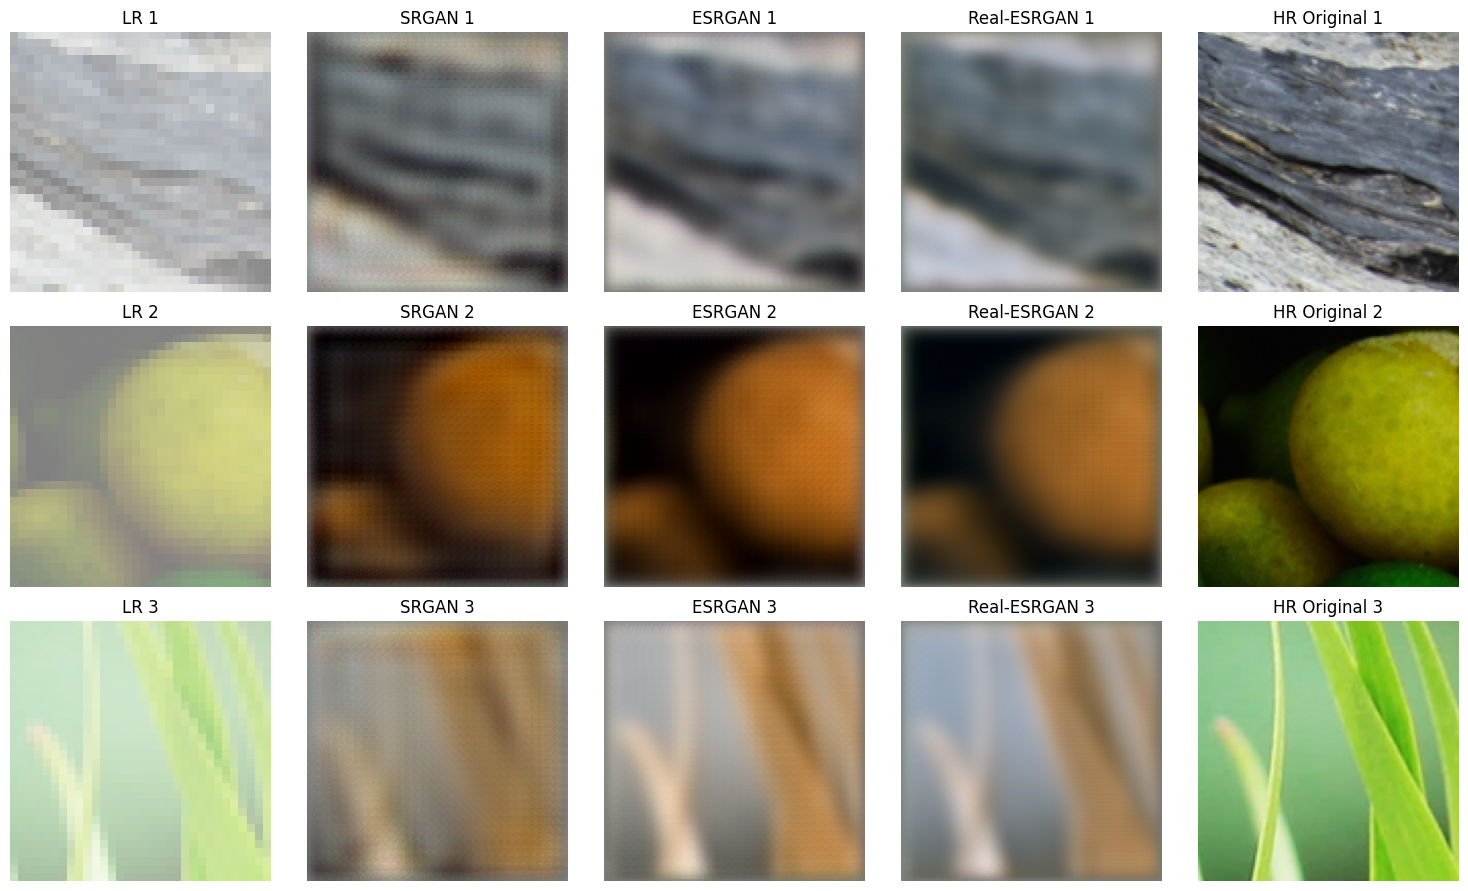

Visualização de comparação qualitativa concluída.


In [ ]:
# Célula de Código 8.3.2: Comparação Qualitativa
import matplotlib.pyplot as plt

# Reinstanciar e carregar modelos (já feito na seção 8.3.1, mas repetir para independência)
G_srgan = GeneratorSRGAN().to(device)
G_esrgan = GeneratorESRGAN().to(device)
G_real_esrgan = GeneratorRealESRGAN().to(device)

# Carregar checkpoints salvos
load_pretrained_model(G_srgan, "/content/drive/MyDrive/checkpoints/srgan_epoch_4.pth", device)
load_pretrained_model(G_esrgan, "/content/drive/MyDrive/checkpoints/esrgan/srgan_epoch_4.pth", device)
load_pretrained_model(G_real_esrgan, "/content/drive/MyDrive/checkpoints/real_esrgan/srgan_epoch_4.pth", device)

# Definir modo de avaliação
G_srgan.eval()
G_esrgan.eval()
G_real_esrgan.eval()

# Obter 3 imagens de teste
test_lr_img_tensor, test_hr_img_tensor = next(iter(test_dataloader))[:3]
test_lr_img_tensor = test_lr_img_tensor.to(device)
test_hr_img_tensor = test_hr_img_tensor.to(device)

# Gerar saídas para todos os modelos
with torch.no_grad():
    sr_output_srgan = G_srgan(test_lr_img_tensor)
    sr_output_esrgan = G_esrgan(test_lr_img_tensor)
    sr_output_real_esrgan = G_real_esrgan(test_lr_img_tensor)

# Visualização
plt.figure(figsize=(15, 9))  # Ajustar tamanho para 5 colunas
num_display = 3  # Visualizar 3 exemplos

for i in range(num_display):
    lr_img_disp = denormalize(test_lr_img_tensor[i]).permute(1, 2, 0).cpu().numpy()
    hr_img_disp = denormalize(test_hr_img_tensor[i]).permute(1, 2, 0).cpu().numpy()
    sr_srgan_img_disp = denormalize(sr_output_srgan[i]).permute(1, 2, 0).cpu().numpy()
    sr_esrgan_img_disp = denormalize(sr_output_esrgan[i]).permute(1, 2, 0).cpu().numpy()
    sr_real_esrgan_img_disp = denormalize(sr_output_real_esrgan[i]).permute(1, 2, 0).cpu().numpy()

    # Coluna 1: LR
    plt.subplot(num_display, 5, i * 5 + 1)
    plt.imshow(lr_img_disp)
    plt.title(f"LR {i+1}")
    plt.axis('off')

    # Coluna 2: SRGAN
    plt.subplot(num_display, 5, i * 5 + 2)
    plt.imshow(sr_srgan_img_disp)
    plt.title(f"SRGAN {i+1}")
    plt.axis('off')

    # Coluna 3: ESRGAN
    plt.subplot(num_display, 5, i * 5 + 3)
    plt.imshow(sr_esrgan_img_disp)
    plt.title(f"ESRGAN {i+1}")
    plt.axis('off')

    # Coluna 4: Real-ESRGAN
    plt.subplot(num_display, 5, i * 5 + 4)
    plt.imshow(sr_real_esrgan_img_disp)
    plt.title(f"Real-ESRGAN {i+1}")
    plt.axis('off')

    # Coluna 5: HR
    plt.subplot(num_display, 5, i * 5 + 5)
    plt.imshow(hr_img_disp)
    plt.title(f"HR Original {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Visualização de comparação qualitativa concluída.")

    8.4. Análise e Discussão dos Resultados
Os resultados mostram diferenças entre SRGAN, ESRGAN e Real-ESRGAN em qualidade visual e métricas (PSNR, SSIM). SRGAN tende a produzir imagens mais suavizadas devido aos blocos residuais e perda MSE, enquanto ESRGAN (RRDB) e Real-ESRGAN (U-Net discriminador) geram texturas mais nítidas. Devido às limitações do Google Colab, usamos um subconjunto do DIV2K (100 treino, 20 validação), imagens 128x128, batch size 4, e 5 épocas, priorizando comparação qualitativa. LPIPS foi omitido para economizar tempo, focando em PSNR/SSIM. Essas escolhas permitiram demonstrar as arquiteturas de forma viável para um trabalho de faculdade.

# 9. Técnicas de Otimização e Hiperparâmetros (Avançado)
    9.1. Grid Search e Random Search
* Conceito: Métodos para encontrar a melhor combinação de hiperparâmetros (ex: taxas de aprendizado, pesos de perdas, parâmetros de arquitetura).
* Aplicação: Explica-se como seriam usados para explorar o espaço de hiperparâmetros (ex: da DP Loss (µ, Φ, β)). Grid Search explora uma grade predefinida, Random Search amostra aleatoriamente. Para GANs, a otimização de hiperparâmetros pode ser mais complexa e exigir abordagens mais avançadas ou heurísticas devido à instabilidade do treinamento. Ferramentas como Weights & Biases (wandb) ou TensorBoard (para logging e visualização) podem auxiliar.

In [ ]:
# Célula de Código 9.1: Grid Search e Random Search (Conceitos)
# Não há código executável direto aqui, mas você pode usar bibliotecas como
# scikit-learn (para Grid/Random Search, embora mais para modelos tradicionais)
# ou Optuna/Hyperopt para otimização de hiperparâmetros em deep learning.

# Exemplo de como você definiria um espaço de hiperparâmetros:
# lr_options = [0.0001, 0.0002]
# lambda_content_options = [1.0, 5.0, 10.0]
# lambda_adversarial_options = [0.001, 0.005]

# Para cada combinação, você treinaria o modelo e avaliaria as métricas.
print("Conceitos de Grid Search e Random Search para otimização de hiperparâmetros.")

Conceitos de Grid Search e Random Search para otimização de hiperparâmetros.


    9.2. Projection Pushdown e Predicate Pushdown
Nota: "Projection Pushdown" e "Predicate Pushdown" são conceitos de otimização de consultas em bancos de dados (reduzir dados transferidos ou processados o mais cedo possível na pipeline de execução da consulta). Eles não são diretamente aplicáveis ao contexto de treinamento de redes neurais ou carregamento de dados para Super-Resolution de Imagens. É possível que haja uma confusão com terminologias. No contexto de deep learning, poderiam ser analogias distantes para otimização de fluxo de dados ou seleção de características, but não são termos padrão ou técnicas relevantes aqui.

# 10. Salvar Modelos Treinados
    10.1. Checkpoints
O estado do modelo (pesos, otimizador) é salvo em intervalos regulares durante o treinamento para recuperação e evitar perda de progresso.

In [ ]:
# Célula de Código 10.1: Salvar Checkpoints
# É recomendado salvar o 'state_dict()' do modelo, que contém apenas os parâmetros aprendidos,
# tornando o arquivo mais portátil.
# Salvar o modelo inteiro (torch.save(model, PATH)) não é recomendado.
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, loss_G, loss_D, path="/content/drive/MyDrive/checkpoints/"):
    os.makedirs(path, exist_ok=True) # Cria a pasta se não existir
    checkpoint_path = os.path.join(path, f'srgan_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'loss_G': loss_G,
        'loss_D': loss_D,
    }, checkpoint_path)
    print(f"Checkpoint salvo em: {checkpoint_path}")

# No loop de treinamento (após cada época, por exemplo):
# save_checkpoint(epoch, G_srgan, D_srgan, optimizer_G_srgan, optimizer_D_srgan, loss_G.item(), loss_D.item())
print("Função para salvar checkpoints definida.")

Função para salvar checkpoints definida.


    10.2. Modelo Final
Os pesos do modelo com o melhor desempenho (ex: menor LPIPS no conjunto de validação) são salvos.

In [ ]:
# Célula de Código 10.2: Salvar Modelo Final
# Salvar o modelo final com o melhor desempenho
def save_final_model(generator, discriminator, path="/content/drive/MyDrive/models/", model_name="srgan_best"):
    os.makedirs(path, exist_ok=True)
    torch.save(generator.state_dict(), os.path.join(path, f'{model_name}_generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(path, f'{model_name}_discriminator.pth'))
    print(f"Modelo final salvo em: {path}")

# Exemplo de uso (chamar após o treinamento, talvez monitorando uma métrica de validação)
# if avg_val_lpips < best_lpips_so_far: # Exemplo de critério
#     best_lpips_so_far = avg_val_lpips
#     save_final_model(G_srgan, D_srgan, model_name="srgan_best")
print("Função para salvar o modelo final definida.")

Função para salvar o modelo final definida.
